In [1]:
import numpy as np
import matplotlib.pyplot as plt
import field
import spatial
import timesteppers
import scipy.sparse.linalg as spla
from scipy.integrate import trapz
from scipy import sparse

from timesteppers import *

from field import *
from spatial import *
from spatial import FiniteDifferenceUniformGrid

%matplotlib inline


### $N(E) = 4\pi^2p(E)f(E,t)$

### $\frac{\partial N}{\partial t} = -\frac{\partial F_E}{\partial E} \rightarrow \frac{\partial f}{\partial t} = -\frac{1}{4\pi^2 p(E)}\frac{\partial F_E}{\partial E}$
### $F_E = - D_{EE}\frac{\partial f}{\partial E} - D_Ef$

### $\frac{\partial f}{\partial t} = \frac{1}{4\pi^2 p(E)}\left(\frac{\partial D_{EE}}{\partial E}\frac{\partial f}{\partial E} + D_{EE}\frac{\partial^2 f}{\partial E^2} + \frac{\partial D_E}{\partial E}f + D_E\frac{\partial f}{\partial E}\right)$

In [271]:
G = 6.674e-8 # gravitational constant, cgs
m = 2e33     # 1 solar mass in grams
M = 2e37     # 1e8 solar mass SMBH
N = 1e4      # number of stars in distribution
Rstar = 7e10 #stellar radius in cm
Rt = Rstar*(M/m)**(1/3)
Et = G*M/(2*Rt)

class FokkerPlanck_SC:
    
    def __init__(self, X, rgrid, f0 = 1, spatial_order=4):
      
        self.X = X
        self.r = rgrid
        f = self.X.field_list[0]
        
        self.domain = f.domain
        self.spatial_order = spatial_order

        
        # Returns field.Array instances: 
        self.dE  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=0)
        self.dE2 = FiniteDifferenceUniformGrid(2, spatial_order, f, axis=0)        
        
        self.f0 = f0
                
        self.t = 0.
        self.iter = 0

    def _potential(self,r):
        # For now, assumes SMBH potential
        return G*M/r
        
    def _calc_pq(self):
        f = self.X.field_list[0]
        
        grid_E = f.domain.grids[0]
        
        E = grid_E.values[:,None]
        r = self.r.values[None,:]
        
        pot = self._potential(r)
        
        ### NANs are produced here
        v = np.sqrt(2*pot - 2*E)

        p_integrand = r*r*v
        q_integrand = r*r*v**3.
        
        # Cohn 1980: we want to ingreate p, q from 0 to pot^(-1) at a given E
        r_upper = (G*M)/((v*v + 2*E)/2.)
        exclude_upper = r >= r_upper
        
        
        ## Should think about this step more - we are just removing all nans by hand
        exclude_vnans = np.isnan(v)
        
        exclude = np.logical_or(exclude_upper,exclude_vnans)
        
        ## Assuming integrates over all radius: 
        p_integrand[exclude_vnans] = 0
        q_integrand[exclude_vnans] = 0
        
        p = 4*trapz(p_integrand, r, axis=-1)
        q = (4/3)*trapz(q_integrand, r, axis=-1)
        
        return p, q
    
    def _calc_diffusion(self):
        
        # calculate p and q which are functions of E
        p, q = self._calc_pq()
        
        if self.iter==0:
            print("p = ", p.max(), p.min())
            print("q = ", q.max(), q.min())
            
        E  = grid_E.values[:,None]
        Ep = grid_E.values[None,:]
        
        # define Gamma
        Lambda = M/m # p8 of Vasiliev 2017
        Gamma = 4*np.pi*G*G*m*m * np.log(Lambda)
        
        # calc D_EE, D_E    
        
        f = self.X.field_list[0]
        
        f_arg = np.copy(f.data)[None,:] # extend to E dimension with [:,None]

        # maximum value of potential
        phi_0 = self._potential(np.min(self.r.values)) 
        
        # Booleans to apply bounds
        exclude_upper = Ep >= phi_0
        exclude_lower = Ep <= E
        exclude_both  = np.logical_or(exclude_upper, exclude_lower)
        
        # Define integrands
        D_EE_integrand_1 = np.copy(f_arg)*(Ep>0)*(Ep<E)
        D_EE_integrand_2 = q*f_arg*(Ep<phi_0)*(Ep>E)
        D_E_integrand    = p*f_arg*(Ep<phi_0)*(Ep>E)
        
        # Apply bounds to integrands
        # If no nans, this step is redundant
        D_EE_integrand_2[exclude_both] = 0
        D_E_integrand[exclude_both]    = 0
        
        # Calculate D_EE, D_E from integrands
        D_EE = 16*(np.pi**3.)*Gamma*(q*trapz(D_EE_integrand_1,Ep,axis=-1) + trapz(D_EE_integrand_2,Ep,axis=-1))
        D_E  = -16*(np.pi**3.)*Gamma*trapz(D_E_integrand,Ep,axis=-1)
        
        return D_EE, D_E
                
    def _calc_coefficients(self):
        D_EE, D_E = self._calc_diffusion()        
    
        domain = self.X.field_list[0].domain
        return field.Array(domain,D_EE), field.Array(domain,D_E)
    
    def _recalc_equation(self):        
        D_EE, D_E  = self._calc_coefficients()
        f       = self.X.field_list[0]

        domain  = f.domain
        
        
        dE_D_EE_field = FiniteDifferenceUniformGrid(1, self.spatial_order, D_EE, axis=0).operate()
        dE_D_E_field  = FiniteDifferenceUniformGrid(1, self.spatial_order, D_E, axis=0).operate()
        '''dE_D_EE_field_BCs = [Left(0,4,dE_D_EE_field,0,axis=0),Right(0,4,dE_D_EE_field,0,axis=0)]
        dE_D_E_field_BCs = [Left(0,4,dE_D_E_field,0,axis=0),Right(0,4,dE_D_E_field,0,axis=0)]
        dE_D_EE_field_BCs[0].operate()
        dE_D_EE_field_BCs[1].operate()
        dE_D_E_field_BCs[0].operate()
        dE_D_E_field_BCs[1].operate()'''
        
        dE_D_EE = field.Array(domain, dE_D_EE_field.data)
        dE_D_E  = field.Array(domain, dE_D_E_field.data)
        
        if 0:#self.iter % 100 == 0:
            #plt.plot(f.domain.grids[0].values, np.abs(D_EE.data),label='D_EE.data')
            #plt.plot(f.domain.grids[0].values, np.abs(D_E.data),label='D_E.data')
            #plt.plot(f.domain.grids[0].values, dE_D_EE.data,label='dE_D_EE.data')
            plt.plot(f.domain.grids[0].values, dE_D_E.data,label='dE_D_E.data')
            plt.legend(loc='best',frameon=False)
            
            #plt.yscale('log')
            plt.show()
            plt.clf()
            print('dE_D_EE: ', type(dE_D_EE), dE_D_EE.data.min(), dE_D_EE.data.max())
            print('dE_D_E: ',  type(dE_D_E),  dE_D_E.data.min(), dE_D_E.data.max())
            print('D_EE: ', type(D_EE), D_EE.data.min(), D_EE.data.max())
            print('D_E: ',  type(D_E),  D_E.data.min(), D_E.data.max())
            print('term 1 = ', np.abs(D_EE.data*self.dE2.operate().data).max(), (np.abs(D_EE.data*self.dE2.operate().data).min()))
            print('term 3 = ', np.abs(dE_D_EE.data*self.dE.operate().data).max(), (np.abs(dE_D_EE.data*self.dE.operate().data).min()))
        #print('D_E: ', D_E.data.min(), D_E.data.max())
        if self.iter == 0: print('D_EE: ', D_EE.data.min(), D_EE.data.max())
        
        
        p, q = self._calc_pq()
        p_inv_array = field.Array(domain, 1./p)
        
        if self.iter == 0: print("p_inv_array = ", (1./4./np.pi/np.pi)*p_inv_array.data.max(), (1./4./np.pi/np.pi)*p_inv_array.data.min())
        
        ft     = field.Field(domain)
        
        self.BCs = [Left(0,spatial_order,f,self.f0,axis=0),Right(0,spatial_order,f,0,axis=0)]
        
        LHS = ft - p_inv_array*(1./4./np.pi/np.pi)*(D_EE*self.dE2 + D_E*self.dE + dE_D_EE*self.dE + dE_D_E*f)
        #p_inv_array*(1./4./np.pi/np.pi)*(D_EE*self.dE2 - D_E*self.dE - dE_D_EE*self.dE - dE_D_E*f)
        
        M = LHS.field_coeff(ft)
        self.M = M
    
        L = LHS.field_coeff(f)
        self.L = L
        
        
    def step(self, dt):
        
        self._recalc_equation()
        self.BCs[0].operate()
        self.BCs[1].operate()
        self.ts = CrankNicolson(self,axis=0)
        self.ts.step(dt)
        self.t += dt
        self.iter += 1

8850846821580483.0 4.425423410790242e+17
IC =  6.7823983837628366e-65 2.658972092396765e-71
2.658972092396765e-71 6.7823983837628366e-65


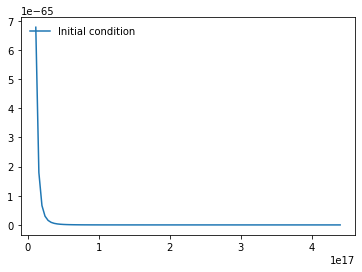

t_relax =  104427.41591143646
q oom =  1.1424346014828891e+67
p oom =  1.7229105155692403e+81
Lambda =  9.210340371976184
diff order of mag =  1.0314888815405962e-05
characteristic evolution time =  1.8986508449339554e+40
nu =  9.999999999999999e+92
dt_fiducial =  1.8808831219125425e-62
t_max =  1.504706497530034e-59
p =  2.07236592214513e+50 8.359619260212448e+45
q =  1.5091761097241577e+66 8.451909686645497e+62
D_EE:  2.465917786113261e+71 1.6666467631543454e+74
p_inv_array =  3.030077701163236e-48 1.222288768595691e-52


/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
<ipython-input-281-4ec260718dff>:92: RuntimeWarning: invalid value encountered in sqrt
  integrand = (G*M/r - E)**(0.5) * solution
<ipython-input-271-e177abf03111>:45: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt(2*pot - 2*E)
/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
<ipython-input-281-4ec260718dff>:92: RuntimeWarning: invalid value encountered in sqrt
  integrand = (G*M/r - E)**(0.5) * solution
<ipython-input-271-e177abf03111>:45: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt(2*pot - 2*E)
/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/

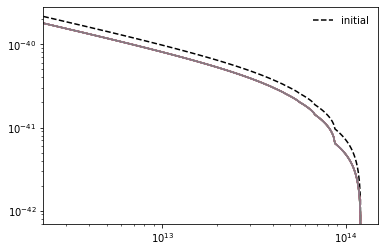

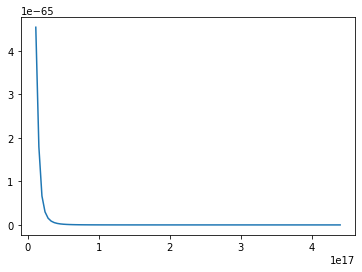

<Figure size 432x288 with 0 Axes>

In [281]:
N = 100
spatial_order = 4

a = 0.4
b = 0.5

#E_min = 1e-3
rmax  = 100*Rt
E_min = G*M/(rmax) # need 1.5 safety factor to avoid unbound orbits

print(E_min,Et)

grid_E = field.UniformNonPeriodicGrid(N,[E_min,Et])

'''IC = np.exp(-(grid_E.values-np.median(grid_E.values))**2./1e40)
print("IC = ", IC.max(), IC.min())
IC *= (1/(4*np.pi*np.pi*p_oom*Et)) * N
print("IC = ", IC.max(), IC.min())'''


#IC = np.exp( -5*(Et-grid_E.values)/(Et-grid_E.values) + 1)
IC  = grid_E.values**(-4.)
print("IC = ", IC.max(), IC.min())

p_oom = 4*rmax**(5./2.) * (G*M)**(3./2.)



print(IC.min(),IC.max())


plt.plot(grid_E.values, IC, label='Initial condition')
plt.legend(loc='upper left',frameon=False)
plt.show()
plt.clf()


domain = field.Domain((grid_E,))
f = field.Field(domain)

f.data = np.copy(IC)

X = field.FieldSystem([f])

rgrid = field.UniformNonPeriodicGrid(N,[Rt,rmax])


E_data = np.copy(grid_E.values)
r_data = np.copy(rgrid.values)


FP_SC = FokkerPlanck_SC(X,rgrid,f0=np.max(IC))


#t_relax = 0.1*N/(np.log(N))*rmax/v
t_relax = 0.0600 * M**(1/2)*Rt**(3/2)/m/G**(1/2)/np.log(M/m)
print("t_relax = ", t_relax)

q_oom = 4*rmax**(3./2.) * (G*M)**(3./2.)
p_oom = 4*rmax**(5./2.) * (G*M)**(3./2.)
print("q oom = ", q_oom)
print("p oom = ", p_oom)
print("Lambda = ", np.log(M/m))
Gamma = np.log(M/m)*4*np.pi*G*G*m*m
diff_oom =  (q_oom*np.max(IC)*(G*M/Rt)*Gamma*16*np.pi**3.)/(4*np.pi*np.pi*p_oom)
print("diff order of mag = ", diff_oom)
print("characteristic evolution time = ", Et*Et/diff_oom)
#diff_oom =  q_oom*np.max(IC)*(G*M/Rt)*Gamma*16*np.pi**3.
#print("diff order of mag = ", diff_oom)

dE = E_data[1]-E_data[0]

nu = 1e150*1e-57#diff_oom
print("nu = ", nu)
dt_fiducial = dE*dE/nu
alpha = 1
dt = alpha*dt_fiducial
print("dt_fiducial = ", dt_fiducial)
#dt = alpha*t_relax#alpha*dE**2.#t_relax
t_max = dt_fiducial*800
print("t_max = ", t_max)        

    
R_ind = N//2

#### calculate mass from solution
def _calc_density(solution, Egrid, rgrid):
    E = Egrid[None,:]
    r = rgrid[:,None]
    solution = solution[None,:]
    pot = G*M/r
    integrand = (G*M/r - E)**(0.5) * solution
    integrand[np.isnan(integrand)] = 0

    return trapz(integrand,E,axis=-1)



rho_IC  = _calc_density(IC, E_data, r_data)
plt.plot(r_data, rho_IC, color='black', ls='--', label='initial')
while FP_SC.t < t_max:
    FP_SC.step(dt)

    if FP_SC.iter % 100 == 0:
        rho_sol = _calc_density(f.data, E_data, r_data)
        plt.plot(r_data, rho_sol)
        
plt.legend(loc='best',frameon=False)
plt.xscale('log')
plt.yscale('log')
plt.xlim(r_data.min(),r_data.max())
plt.show()
plt.clf()

plt.plot(E_data, f.data)
plt.show()
plt.clf()

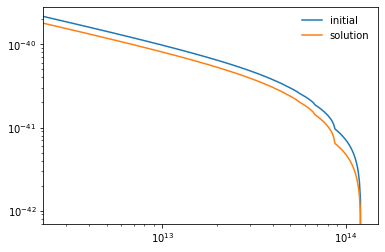

<Figure size 432x288 with 0 Axes>

In [282]:
plt.plot(r_data, rho_IC, label='initial')
plt.plot(r_data, rho_sol, label='solution')
plt.legend(loc='best',frameon=False)
plt.xscale('log')
plt.yscale('log')
plt.xlim(r_data.min(),r_data.max())
plt.show()
plt.clf()